## Chargement des librairies utilisées

In [2]:
%matplotlib inline
import numpy as np

import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import scipy as sp
from scipy import sparse
from scipy import optimize

## Définitions des différents algorithmes utilisés

### Algorithme de gradient à pas fixe

On implémente ici la méthode du gradient à pas fixe. 
Les arguments sont : la fonctionnelle à minimiser `f`, son gradient `df` et un point initial `x_init`. On y ajoute les arguments optionnels suivants : le pas du gradient `pas`, la tolérance demandée `tol` et le nombre maximal d'itérations `maxiter`.

On construit la suite $x_k$ définie par :

\begin{equation}
\left\{
\begin{aligned}
&x_0 \in \mathbb R^n \text{ quelconque ;} \\
&x_{k+1} = x_k - \mu \nabla J(x_k),
\end{aligned}
\right.
\end{equation}

où $\mu >0$ est le pas de l'algorithme.

In [3]:
def gradientPasFixe(f,df,x_init,pas=1e-01,tol=1e-06,maxiter=200):
    
    # initialisation
    x=x_init.copy()
    xtab=[]
    ftab=[]
    
    xtab.append(x) # on ajoute x à la liste xtab
    ftab.append(f(x))
    
    it=0 # compteur d'itération
    
    while((it==0) or (it<maxiter and np.linalg.norm(df(xtab[-1]))>tol)):
    
        x=x-pas*df(x)
        
        xtab.append(x)
        ftab.append(f(x))
        
        it=it+1
    
    # booléen pour indiquer la convergence
    # np.isnan renvoie "False" si la quantité est bien un nombre et "True" sinon  
    if(it==maxiter) or (np.isnan(np.linalg.norm(x))==True):
        conv = False
    else:
        conv = True
    
    return xtab, ftab, conv
    

### Algorithme du gradient pas optimal

On construit la suite $x_k$ définie par :

\begin{equation}
\left\{
\begin{aligned}
&x_0 \in \mathbb R^n \text{ quelconque} \\
&x_{k+1} = x_k - \mu_k \nabla J(x_k),
\end{aligned}
\right.
\end{equation}

où le pas de descente $\mu_k$ est choisi tel que :

$$ J(x_{k+1})=\min_{\mu \in \mathbb R} J(x_k-\mu\nabla J(x_k)).$$

Lorsqu'on travaille avec une fonctionnelle quadratique  $J: \mathbb R^2 \rightarrow \mathbb R$ telle que  
$$ J(x) = \frac12 \langle Ax,x\rangle - \langle b,x\rangle,$$
avec $A$ une matrice symétrique définie positive, on sait que le pas de descente optimal est donné par 
$$\mu_k=\frac{\|r_k\|^2}{\left\langle r_k,Ar_k\right\rangle} \text{ avec } r_k= Ax_k-b.$$

On ajoute donc comme argument optionnel la variable `fct_quad` qui vaudra la matrice $A$ dans ce cas et $0$ sinon (valeur par défaut). Dans ce dernier cas, le pas optimal est trouvé en utilisant la routine "optimize.line_search" de Python.

De plus il peut être intéressant de connaître le pas optimal à chaque itération. On ajoute donc également l'argument optionnel `affichage_pas` qui permet :
- d'afficher le pas à toutes les itérations lorsque cette variable sera égale à $1$ ;
- d'afficher le pas seulement pour les 10 premières itérations lorsque cette variable sera égale à $2$ ;
- de ne pas afficher le pas lorsque cette variable est égale à $0$ (valeur par défaut).

In [4]:
def gradientPasOpt(f,df,x_init,tol=1e-06,maxiter=200,fct_quad=np.array([0]),affichage_pas=0):
    
    # initialisation
    x=x_init.copy()
    xtab=[]
    ftab=[]
    
    xtab.append(x) # on ajoute x à la liste xtab
    ftab.append(f(x))
    
    it=0 # compteur d'itération
    
    while((it==0) or (it<maxiter and np.linalg.norm(df(xtab[-1]))>tol)):
        
        if fct_quad.shape[0] > 1:            
            r=df(x)
            pas = np.dot(r,r)/np.dot(r,fct_quad@r)
        else:
            pas_opt = optimize.line_search(f,df,x,-df(x))
            pas=pas_opt[0]
            if (pas == None):
                
                raise ValueError("L algorithme line_search n a pas convergé")
        
        if (affichage_pas==1):
            print('Pas optimal = ',pas, 'à l itération ',it)
            
        elif (affichage_pas==2) and (it<10):
            print('Pas optimal = ',pas, 'à l itération ',it)
            
        x=x-pas*df(x)
        
        xtab.append(x)
        ftab.append(f(x))
        
        it=it+1
    
    # booléen pour indiquer la convergence
    # np.isnan renvoie "False" si la quantité est bien un nombre et "True" sinon 
    if(it==maxiter) or (np.isnan(np.linalg.norm(x))==True):
        conv = False
    else:
        conv = True
    
    return xtab, ftab, conv

### Algorithme du gradient conjugué

On propose ici l'algorithme du gradient conjugué appliqué à la fonctionnelle quadratique $J: \mathbb R^2 \rightarrow \mathbb R$ telle que  
$$ J(x) = \frac12 \langle Ax,x\rangle - \langle b,x\rangle,$$
où $A\in\mathcal M_n(\mathbb R)$ est une matrice symétrique définie positive.

Dans ce cas l'algorithme s'écrit de la manière suivante :

\begin{equation}
\left\{
\begin{aligned}
 & x_0\text{ étant donné, on calcule } r_0=Au_0-b \text{ et }p_0=r_0.\\
  &\text{Pour }k=1,2,\ldots\text{, on calcule :}\\
  &\left\{
  \begin{aligned}
  \mu_k&=\frac{\|r_k\|^2}{\langle A p_k, p_k \rangle},\\
  x_{k+1}&=x_k - \mu_k p_k,\\
  r_{k+1} &= r_k - \mu_k A p_k.
 \end{aligned}
 \right.\\
 &\text{Si }\|r_k\|< \varepsilon ||b||\text{ alors on s'arrête.}\\
 &\text{Sinon }
 \left\{
\begin{aligned}
\beta_k &= \frac{\|r_{k+1}\|^2}{\|r_k\|^2},\\
 p_{k+1}&=r_{k+1} + \beta_k p_k.
\end{aligned}
\right.
 \end{aligned}
 \right.
\end{equation}

On observera que par itération seuls un produit scalaire,
deux calculs de norme et un produit matrice vecteur sont nécessaires.

In [5]:
def gradientConjugue(A,b,f,x_init,tol=1e-06,maxiter=200):
    
    # initialisation
    x=x_init.copy()
    r=A@x-b
    p=r.copy()
    
    ps_r=np.dot(r,r)
    norm_b=np.dot(b,b)
    
    xtab=[]
    ftab=[]
    xtab.append(x) # on ajoute x à la liste xtab
    ftab.append(f(x))
    
    it=0 # compteur d'itération

    while((it==0) or (it<maxiter and ps_r>tol*norm_b)):
        
        # Calcul du produit matriciel A p_k
        Ap=A@p

        # Calcul de mu_k
        mu=ps_r/np.dot(Ap,p)

        # Calcul de x_{k+1}
        x=x-mu*p

        # Calcul de r_{k+1}
        r=r-mu*Ap

        # Calcul du produit scalaire <r_{k+1},r_{k+1}> 
        ps_rnew=np.dot(r,r)

        # Calcul de beta_{k+1}
        beta=ps_rnew/ps_r

        # Calcul de p_{k+1}
        p=r+beta*p

        # On met à jour la valeur du produit scalaire <r_k,z_k>
        ps_r=ps_rnew
        
        xtab.append(x)
        ftab.append(f(x))
        it=it+1
        
    # booléen pour indiquer la convergence
    # np.isnan renvoie "False" si la quantité est bien un nombre et "True" sinon 
    if(it==maxiter) or (np.isnan(np.linalg.norm(x))==True):
        conv = False
    else:
        conv = True
    
    return xtab, ftab, conv
    

### Algorithme de Newton

On applique l'algorithme de Newton à la fonction $\nabla J$.
On construit alors la suite $x_k$ définie par :
\begin{equation}
\left\{
\begin{aligned}
&x_0 \in \mathbb R^n \text{ quelconque} \\
&x_{k+1} = x_k - (H_J(x_k))^{-1} \nabla J(x_k),
\end{aligned}
\right.
\end{equation}
où $H_J$ est la hessienne de $J$.

In [6]:
def Newton(f,df,Hf,x_init,tol=1e-06,maxiter=200):
    # initialisation
    x=x_init.copy()
    xtab=[]
    ftab=[]
    xtab.append(x) # on ajoute x à la liste xtab
    ftab.append(f(x))
    it=0 # compteur d'itération
    
    while((it==0) or (it<maxiter and np.linalg.norm(xtab[-1]-xtab[-2])>tol)):
        # pour savoir quel solveur utiliser pour la résolution du système linéaire
        # on regarde si la matrice est creuse ((1*sp.sparse.issparse(Hf(x)))==1) ou pas
        if (1*sp.sparse.issparse(Hf(x)))==1:
            x=x-sp.sparse.linalg.spsolve(Hf(x).tocsc(),df(x))
            
        else:
            x=x-np.linalg.solve(Hf(x), df(x))
            

        xtab.append(x)
        ftab.append(f(x))
        it=it+1
        
    # booléen pour indiquer la convergence
    # np.isnan renvoie "False" si la quantité est bien un nombre et "True" sinon 
    if(it==maxiter) or (np.isnan(np.linalg.norm(x))==True):
        conv = False
    else:
        conv = True
   
    return xtab, ftab, conv


## Exemples d'application

### Application à une fonctionnelle quadratique 

On applique dans un premier temps ces différents algorithmes à la fonctionnelle quadratique $J: \mathbb R^N \rightarrow \mathbb R$ telle que  
$$ J(x) = \frac12 \langle Ax,x\rangle - \langle b,x\rangle,$$
avec :
\begin{equation}
 A=\frac 1 {h^2} 
 \begin{pmatrix}
 2&-1&0&\ldots&0\\
 -1&2&-1&\ddots&\vdots\\
 0&\ddots&\ddots&\ddots&0\\
\vdots&\ddots& -1&2&-1\\
0&\ldots& 0& -1&2
\end{pmatrix} \in \mathcal M _{n}(\mathbb R)\quad
\text{ et } \quad
 b=\begin{pmatrix}
1\\ \vdots\\1 \end{pmatrix}.
\end{equation}

Trouver le minimum de la fonctionnelle $J$ revient alors à résoudre le système linéaire $Ax=b$.

#### Premiers tests sur le gradient à pas fixe

In [7]:
## On construit la matrice A et le vecteur b

N=20
#=50 # en 50 000 itérations ça n'a pas convergé (matrice mal conditionnée)

h=0.1

A_Lap= (1/h**2)*sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(N,N))
b_Lap=np.ones(N)

## On calcule la solution exacte pour vérifier la convergence de l'algorithme
sol_Lap=sp.sparse.linalg.spsolve(A_Lap.tocsc(), b_Lap, use_umfpack=True)

## Définition de la fonctionnelle et de sa dérivée
def J_Lap(x):
    return 0.5*np.dot(x,A_Lap*x)-np.dot(b_Lap,x)

def gradJ_Lap(x):
    return A_Lap*x-b_Lap

x_init_Lap=np.random.randn(N)

Algorithme du gradient à pas fixe avec un pas =  0.00502
Erreur =  2.510924134503267e-09
Convergence = True
Nombre d itérations =  5910
Algorithme du gradient à pas fixe avec un pas =  0.00501
Erreur =  2.5087274459836993e-09
Convergence = True
Nombre d itérations =  2636
Algorithme du gradient à pas fixe avec un pas =  0.005
Erreur =  3.246155633287629e-09
Convergence = True
Nombre d itérations =  1694
Algorithme du gradient à pas fixe avec un pas =  0.001
Erreur =  4.476283079210733e-07
Convergence = True
Nombre d itérations =  6103
Algorithme du gradient à pas fixe avec un pas =  0.0005
Erreur =  4.4754226845508033e-07
Convergence = True
Nombre d itérations =  12213
Algorithme du gradient à pas fixe avec un pas =  0.00025
Erreur =  4.474988138453306e-07
Convergence = True
Nombre d itérations =  24433
Algorithme du gradient à pas fixe avec un pas =  0.0001
Erreur =  5.334151003745097e-06
Convergence = False
Nombre d itérations =  50000


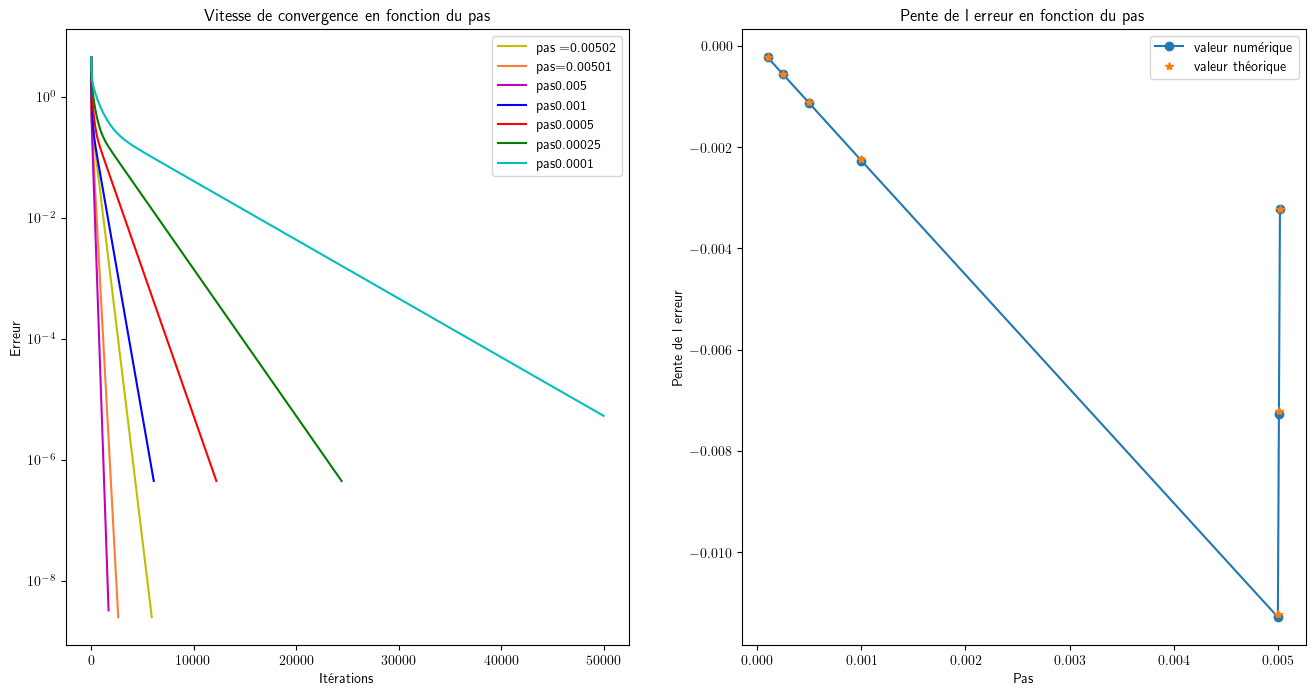

In [8]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16, 8))
v_slope=[]
v_pas=[]

## Tests avec des pas choisis arbitrairement

pas=0.00502
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-y',label='pas ='+str(pas))
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)


pas=0.00501
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),color='#ff7d33',label='pas='+str(pas))
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)


pas=0.005
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-m',label='pas'+str(pas))
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)


pas=0.001
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-b',label='pas'+str(pas))
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)


pas=0.0005
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-r',label='pas'+str(pas))
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)


pas=0.00025
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-g',label='pas'+str(pas))
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)


pas=0.0001
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-c',label='pas'+str(pas))
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)


ax1.set_title('Vitesse de convergence en fonction du pas')
ax1.set_ylabel('Erreur')
ax1.set_xlabel('Itérations')
ax1.legend()

vp,_=np.linalg.eigh(A_Lap.todense())
vp_max=np.max(vp)
vp_min=np.min(vp)
v_gamma=np.maximum(np.abs(1-v_pas*np.full(shape=7,fill_value=vp_min)),np.abs(1-v_pas*np.full(shape=7,fill_value=vp_max)))

ax2.plot(v_pas,v_slope,'o-',label='valeur numérique')
ax2.plot(v_pas,np.log(v_gamma),'*',label='valeur théorique')

ax2.set_title('Pente de l erreur en fonction du pas')
ax2.set_xlabel('Pas')
ax2.set_ylabel('Pente de l erreur')
ax2.legend()

plt.show()


Algorithme du gradient à pas fixe avec un pas =  0.0052


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5488\2064178041.py:15: RuntimeWarning: invalid value encountered in subtract
  x=x-pas*df(x)


Erreur =  nan
Convergence = False
Nombre d itérations =  10672
Algorithme du gradient à pas fixe avec un pas =  0.0051
Erreur =  nan
Convergence = False
Nombre d itérations =  25024


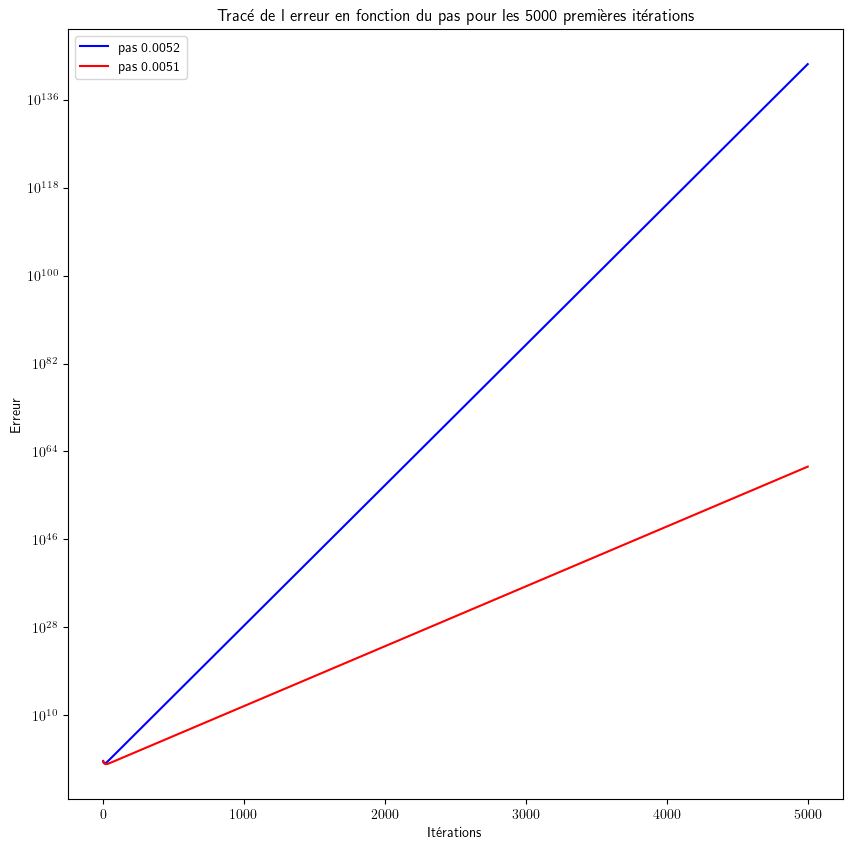

In [9]:
fig=plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

## Test avec un pas légèrement plus grand que 0.05
pas=0.0052
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax.semilogy(np.arange(5000),np.linalg.norm(x_PasFixe_Lap[:5000]-sol_Lap,axis=1),'-b',label='pas 0.0052')


pas=0.0051
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax.semilogy(np.arange(5000),np.linalg.norm(x_PasFixe_Lap[:5000]-sol_Lap,axis=1),'-r',label='pas 0.0051')

ax.set_title('Tracé de l erreur en fonction du pas pour les 5000 premières itérations')
ax.set_ylabel('Erreur')
ax.set_xlabel('Itérations')
ax.legend()

plt.show()

In [10]:
## Test avec le pas donnant la meilleure vitesse de convergence

# Calcul des valeurs propres de la matrice A
vp,_=np.linalg.eigh(A_Lap.todense())
vp_max=np.max(vp)
vp_min=np.min(vp)
pas = 2/(vp_min+vp_max)
pas_max = 2/vp_max
print('vp_min = ',vp_min)
print('vp_max = ',vp_max)

print('=================================')
print('Algorithme du gradient avec le pas donnant la meilleure vitesse de convergence')
print('Pas =',pas)
print('Pas_max=',pas_max)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)

vp_min =  2.2338347549743176
vp_max =  397.7661652450257
Algorithme du gradient avec le pas donnant la meilleure vitesse de convergence
Pas = 0.004999999999999999
Pas_max= 0.0050280797482309516
Erreur =  3.2461557328250138e-09
Convergence = True
Nombre d itérations =  1694


#### Comparaison des différents algortithmes

Dans ce cas on choisit le pas donnant la meilleure vitesse de convergence pour l'algorithme de gradient à pas fixe  et on trace l'erreur entre la solution exacte et la solution approchée en fonction du nombre d'itérations dans chacun des cas.

In [11]:
pas_fixe = 2/(vp_min+vp_max)

print('=================================')
print('Algorithme du gradient à pas fixe')
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas_fixe,1e-6,5000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)

print('=================================')
print('Algorithme du gradient à pas optimal')
x_PasOpt_Lap, f_PasOpt, conv_PasOpt = gradientPasOpt(J_Lap,gradJ_Lap,x_init_Lap,1e-6,5000,A_Lap,2)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasOpt_Lap[-1]))
print('Convergence =',conv_PasOpt)
print('Nombre d itérations = ',np.shape(x_PasOpt_Lap)[0]-1)


print('=================================')
print('Algorithme du gradient conjugué')
x_Conj_Lap, f_Conj, conv_Conj = gradientConjugue(A_Lap,b_Lap,J_Lap,x_init_Lap,tol=1e-06,maxiter=200)
print('Erreur = ',np.linalg.norm(sol_Lap-x_Conj_Lap[-1]))
print('Convergence =', conv_Conj)
print('Nombre d itérations = ',np.shape(x_Conj_Lap)[0]-1)


def HessJ_Lap(x):
    return A_Lap

print('=================================')
print('Algorithme de Newton')
x_Newton_Lap, f_Newton, conv_Newton = Newton(J_Lap,gradJ_Lap,HessJ_Lap,x_init_Lap,tol=1e-06,maxiter=200)
print('Erreur = ',np.linalg.norm(sol_Lap-x_Newton_Lap[-1]))
print('Convergence =',conv_Newton)
print('Nombre d itérations = ',np.shape(x_Newton_Lap)[0]-1)


Algorithme du gradient à pas fixe
Erreur =  3.2461557328250138e-09
Convergence = True
Nombre d itérations =  1694
Algorithme du gradient à pas optimal
Pas optimal =  0.003171512096412172 à l itération  0
Pas optimal =  0.004674494202865927 à l itération  1
Pas optimal =  0.0037388184209468924 à l itération  2
Pas optimal =  0.005231049779785362 à l itération  3
Pas optimal =  0.004016394397554999 à l itération  4
Pas optimal =  0.0056237297275926355 à l itération  5
Pas optimal =  0.004182405120178657 à l itération  6
Pas optimal =  0.005810441591709129 à l itération  7
Pas optimal =  0.0042289626953113425 à l itération  8
Pas optimal =  0.0058382039245156205 à l itération  9
Erreur =  3.394914180829414e-07
Convergence = True
Nombre d itérations =  1209
Algorithme du gradient conjugué
Erreur =  9.873234097405242e-15
Convergence = True
Nombre d itérations =  20
Algorithme de Newton
Erreur =  1.1678799538544363e-15
Convergence = True
Nombre d itérations =  2


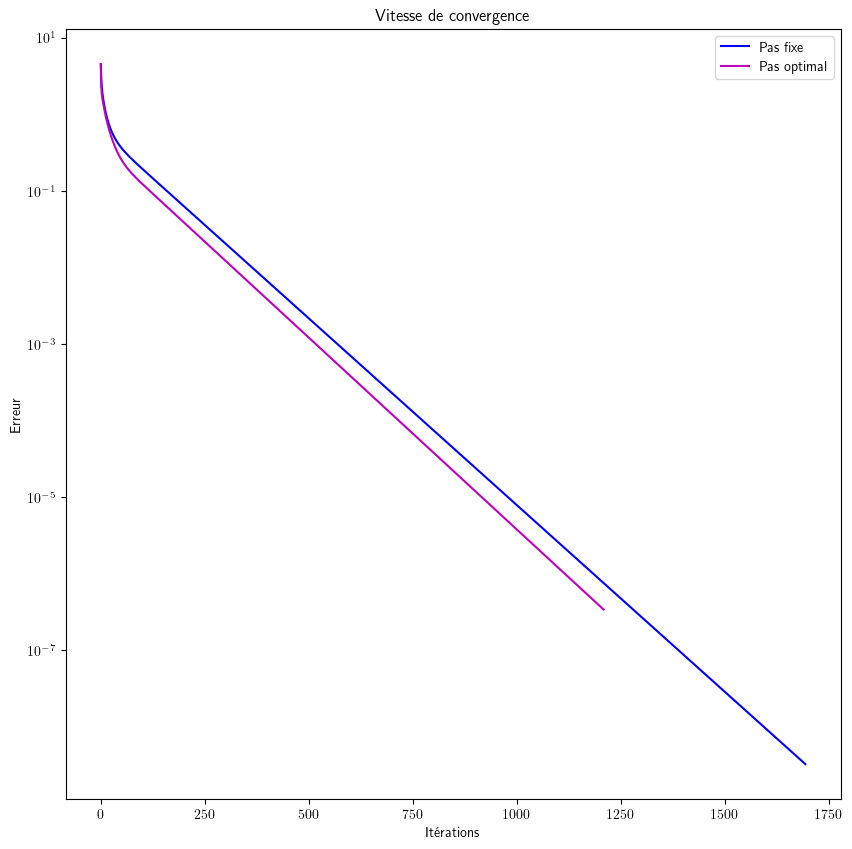

In [12]:
plt.figure(figsize=(10, 10))
plt.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-b')
plt.semilogy(np.linalg.norm(x_PasOpt_Lap-sol_Lap,axis=1),'-m')
plt.legend(['Pas fixe','Pas optimal'])
plt.title('Vitesse de convergence')
plt.xlabel('Itérations')
plt.ylabel('Erreur')
plt.show()

On veut maintenant observer la convergence du critère d'arrêt. On trace donc $\|\nabla J(x_k)\|$ en fonction du nombre d'itérations.

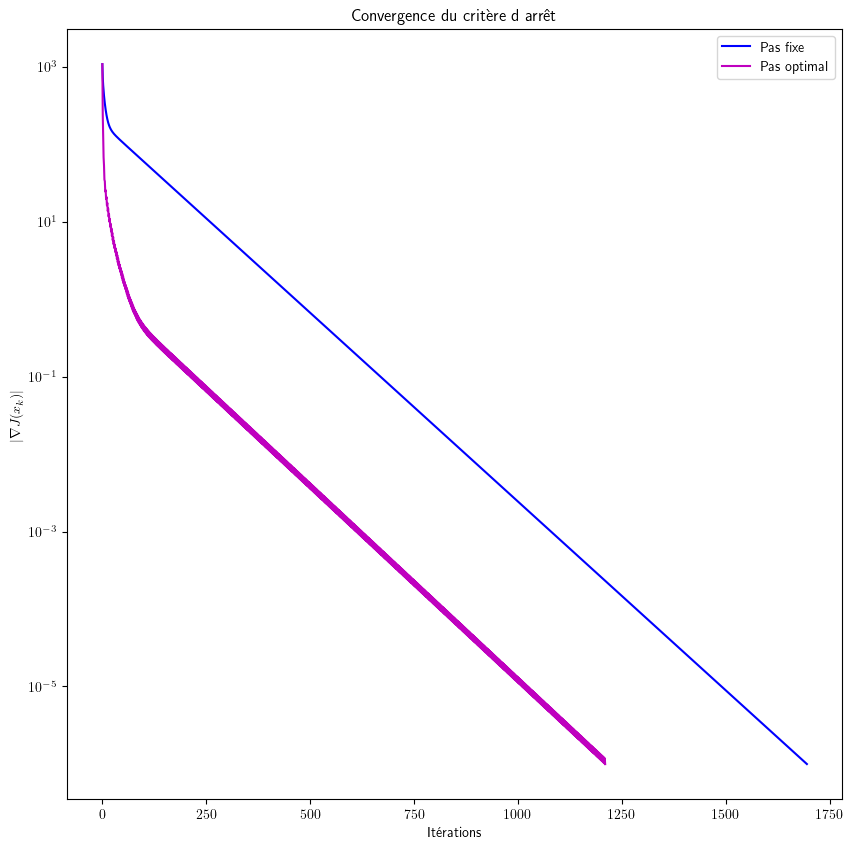

In [13]:
plt.figure(figsize=(10, 10))
plt.semilogy(np.linalg.norm([gradJ_Lap(x_PasFixe_Lap[j]) for j in range(np.shape(x_PasFixe_Lap)[0])],axis=1),'-b')
plt.semilogy(np.linalg.norm([gradJ_Lap(x_PasOpt_Lap[j]) for j in range(np.shape(x_PasOpt_Lap)[0])],axis=1),'-m')
plt.legend(['Pas fixe','Pas optimal'])
plt.title('Convergence du critère d arrêt')
plt.xlabel('Itérations')
plt.ylabel(r'$| \nabla J(x_k)|$')
plt.show()


### Matrices à spectre fixé

On étudie la vitesse de convergence pour des matrices de taille croissante mais ayant toujours le même spectre de valeurs propres.

============= N =  50 =============
Algorithme du gradient à pas fixe
Erreur =  7.317670407917018e-08
Convergence = True
Nombre d itérations =  40
Algorithme du gradient à pas optimal
Erreur =  2.3747753466180623e-07
Convergence = True
Nombre d itérations =  36
Algorithme du gradient conjugué
Erreur =  0.0009448573223337136
Convergence = True
Nombre d itérations =  9
Algorithme de Newton
Erreur =  5.152479160920169e-16
Convergence = True
Nombre d itérations =  2
============= N =  100 =============
Algorithme du gradient à pas fixe
Erreur =  2.3466871241412876e-07
Convergence = True
Nombre d itérations =  40
Algorithme du gradient à pas optimal
Erreur =  3.2348932866402104e-07
Convergence = True
Nombre d itérations =  39
Algorithme du gradient conjugué
Erreur =  0.0007387152771675561
Convergence = True
Nombre d itérations =  10
Algorithme de Newton
Erreur =  1.0947854150276076e-15
Convergence = True
Nombre d itérations =  2
============= N =  1000 =============
Algorithme du gradient à

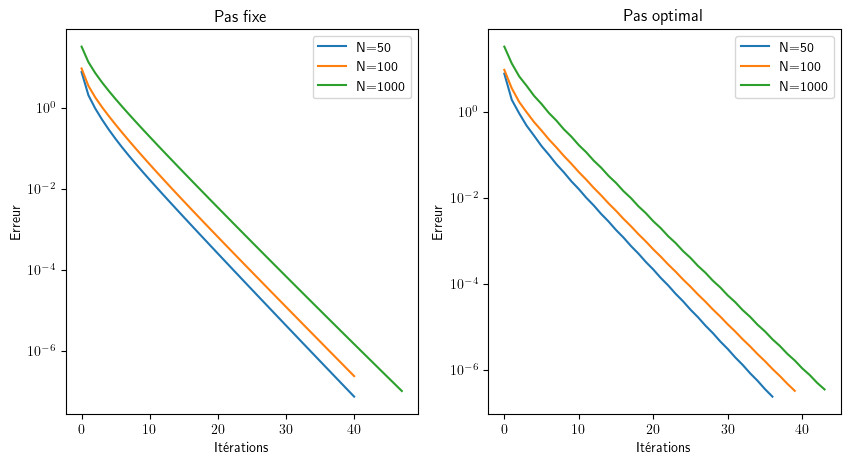

In [14]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,figsize=(10, 5))

for N in np.array([50,100,1000]):
    
    # on construit aléatoirement une matrice H
    H = np.random.randn(N,N)
    
    # on calcule sa décomposition QR
    mat_Q, R = sp.linalg.qr(H)

    # on construit des valeurs propres aléatoires comprises entre 2 et 11
    vp=2+9*np.random.random(N)
    
    # on construit une matrice A ayant ces valeurs propres
    mat_A = sparse.diags(vp,shape=(N,N)) 
    mat_A = mat_Q.T@mat_A@mat_Q

    
    b_spec=np.ones(N)
    
    def J_spec(x):
        return 0.5*np.dot(x,mat_A@x)-np.dot(b_spec,x)

    def gradJ_spec(x):
        return mat_A@x-b_spec
    
    
    sol_spec=np.linalg.solve(mat_A, b_spec)


    x_init=np.random.randn(N)
    
    print('============= N = ', N ,'=============')

    print('=================================')
    print('Algorithme du gradient à pas fixe')
    x_PasFixe_spec, f_PasFixe, conv_PasFixe = gradientPasFixe(J_spec,gradJ_spec,x_init,2/13,1e-6,50000)
    print('Erreur = ',np.linalg.norm(sol_spec-x_PasFixe_spec[-1]))
    print('Convergence =',conv_PasFixe)
    print('Nombre d itérations = ',np.shape(x_PasFixe_spec)[0]-1)

    print('=================================')
    print('Algorithme du gradient à pas optimal')
    x_PasOpt_spec, f_PasOpt, conv_PasOpt = gradientPasOpt(J_spec,gradJ_spec,x_init,1e-6,50000,mat_A)
    print('Erreur = ',np.linalg.norm(sol_spec-x_PasOpt_spec[-1]))
    print('Convergence =',conv_PasOpt)
    print('Nombre d itérations = ',np.shape(x_PasOpt_spec)[0]-1)


    x_Conj_spec, f_Conj, conv_Conj = gradientConjugue(mat_A,b_spec,J_spec,x_init,tol=1e-06,maxiter=200)
    print('=================================')
    print('Algorithme du gradient conjugué')
    print('Erreur = ',np.linalg.norm(sol_spec-x_Conj_spec[-1]))
    print('Convergence =', conv_Conj)
    print('Nombre d itérations = ',np.shape(x_Conj_spec)[0]-1)

    def HessJ_spec(x):
        return mat_A

    print('=================================')
    print('Algorithme de Newton')
    x_Newton_spec, f_Newton, conv_Newton = Newton(J_spec,gradJ_spec,HessJ_spec,x_init,tol=1e-06,maxiter=200)
    print('Erreur = ',np.linalg.norm(sol_spec-x_Newton_spec[-1]))
    print('Convergence =',conv_Newton)
    print('Nombre d itérations = ',np.shape(x_Newton_spec)[0]-1)
    
    ax1.semilogy(np.linalg.norm(x_PasFixe_spec-sol_spec,axis=1),label='N='+str(N))   
    ax2.semilogy(np.linalg.norm(x_PasOpt_spec-sol_spec,axis=1),label='N='+str(N))

    
ax1.set_title('Pas fixe')
ax2.set_title('Pas optimal')


ax1.set_ylabel('Erreur')
ax2.set_ylabel('Erreur')

ax1.set_xlabel('Itérations')
ax2.set_xlabel('Itérations')

ax1.legend()
ax2.legend()


plt.show()

  

### Une fonctionnelle d'ordre 4

\begin{equation}
J(x) =  \frac12 \|x\|^2 \left\langle Ax,x\right\rangle
\end{equation}

In [15]:
N=20
h=1
A= (1/h**2)*sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(N,N))


def J(x):
    return 0.5*np.dot(x,x)*np.dot(x,A*x)

def gradJ(x):
    return np.dot(x,x)*A*x+np.dot(A*x,x)*x

sol=np.zeros(N)


x_init=np.random.randn(N)

print('=================================')
print('Algorithme du gradient à pas fixe')
x_PasFixe, f_PasFixe, conv_PasFixe = gradientPasFixe(J,gradJ,x_init,0.01,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol-x_PasFixe[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe)[0]-1)

print('=================================')
print('Algorithme du gradient à pas optimal')
x_PasOpt, f_PasOpt, conv_PasOpt = gradientPasOpt(J,gradJ,x_init,1e-6,50000,np.array([0]),1)
print('Erreur = ',np.linalg.norm(sol-x_PasOpt[-1]))
print('Convergence =',conv_PasOpt)
print('Nombre d itérations = ',np.shape(x_PasOpt)[0]-1)


def HessJ(x):
    return np.dot(x,x)*A+2*A*x*x.T+np.dot(A*x,x)*sp.sparse.identity(N)+2*x*x.T*A
    

print('=================================')
print('Algorithme de Newton')
x_Newton, f_Newton, conv_Newton = Newton(J,gradJ,HessJ,x_init,tol=1e-06,maxiter=200)
print('Erreur = ',np.linalg.norm(sol-x_Newton[-1]))
print('Convergence =',conv_Newton)
print('Nombre d itérations = ',np.shape(x_Newton)[0]-1)

Algorithme du gradient à pas fixe
Erreur =  0.07728783989555775
Convergence = False
Nombre d itérations =  50000
Algorithme du gradient à pas optimal
Pas optimal =  0.03608100268882048 à l itération  0
Pas optimal =  0.04221450667458499 à l itération  1
Pas optimal =  0.49524279075141125 à l itération  2
Pas optimal =  2.0 à l itération  3
Pas optimal =  4.0 à l itération  4
Pas optimal =  4.0 à l itération  5
Pas optimal =  4.0 à l itération  6
Pas optimal =  4.0 à l itération  7
Pas optimal =  4.0 à l itération  8
Pas optimal =  4.0 à l itération  9
Pas optimal =  8.0 à l itération  10
Pas optimal =  8.0 à l itération  11
Pas optimal =  8.0 à l itération  12
Pas optimal =  8.0 à l itération  13
Pas optimal =  16.0 à l itération  14
Pas optimal =  16.0 à l itération  15
Pas optimal =  16.0 à l itération  16
Pas optimal =  32.0 à l itération  17
Pas optimal =  32.0 à l itération  18
Pas optimal =  32.0 à l itération  19
Pas optimal =  32.0 à l itération  20
Pas optimal =  32.0 à l itér

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


### Fonction non-différentiable

On étudie les algorithmes de gradient sur la fonctionnelle $$J(x)=\|x\|_1=\sum_{i=1}^N |x_i|.$$


In [16]:
def J_norm1(x):
    return np.linalg.norm(x,1)

def gradJ_norm1(x):
    return np.sign(x)

N=20
sol=np.zeros(N)
x_init=np.random.randn(N)


print('=================================')
print('Algorithme du gradient à pas fixe')
x_PasFixe_norm1, f_PasFixe, conv_PasFixe = gradientPasFixe(J_norm1,gradJ_norm1,x_init,0.01,1e-6,50000)
#x_PasFixe_norm1, f_PasFixe, conv_PasFixe = gradientPasFixe(J_norm1,gradJ_norm1,x_init,0.001,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol-x_PasFixe_norm1[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_norm1)[0]-1)


print('=================================')
print('Algorithme du gradient à pas optimal')
x_PasOpt_norm1, f_PasOpt, conv_PasOpt = gradientPasOpt(J_norm1,gradJ_norm1,x_init,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol-x_PasOpt_norm1[-1]))
print('Convergence =',conv_PasOpt)
print('Nombre d itérations = ',np.shape(x_PasOpt_norm1)[0]-1)


Algorithme du gradient à pas fixe
Erreur =  0.028965704058088425
Convergence = False
Nombre d itérations =  50000
Algorithme du gradient à pas optimal


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


ValueError: L algorithme line_search n a pas convergé

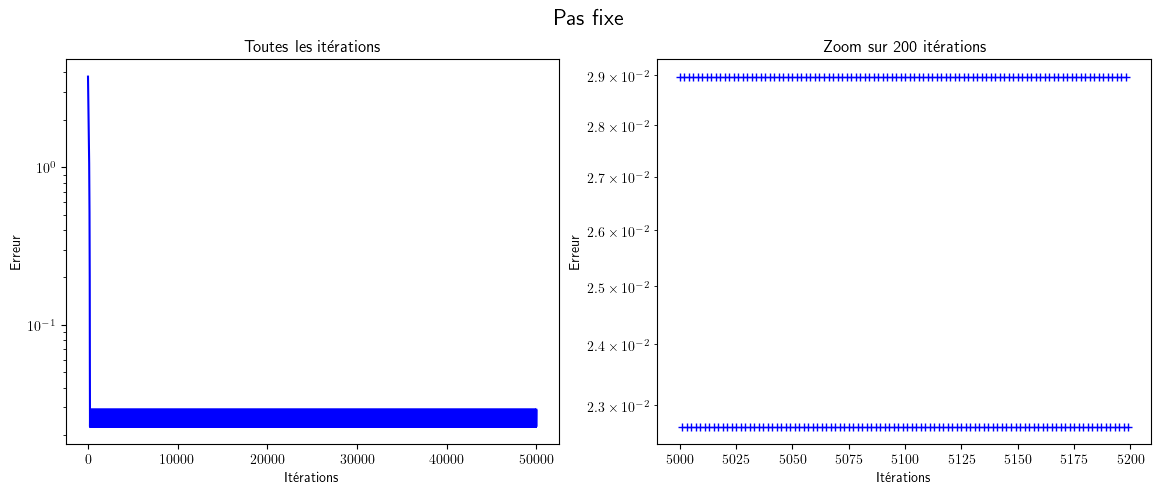

In [17]:
plt.figure(figsize=(14, 5))
plt.clf()

plt.subplot(1,2,1)   
plt.semilogy(np.linalg.norm(x_PasFixe_norm1-sol,axis=1),'b')
plt.title('Toutes les itérations')
plt.xlabel('Itérations')
plt.ylabel('Erreur')

plt.subplot(1,2,2)   
plt.semilogy(np.arange(5000,5200),np.linalg.norm(x_PasFixe_norm1-sol,axis=1)[5000:5200],'+b')
plt.title('Zoom sur 200 itérations')
plt.xlabel('Itérations')
plt.ylabel('Erreur')


plt.suptitle('Pas fixe', fontsize=16)
  
plt.show()